## Imports to determine functionality

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup

import collections
from collections import Counter

import wordcloud
from wordcloud import WordCloud, STOPWORDS

from os import path
from re import sub
from re import compile
from email import message_from_file
from glob import glob


import os
from email import message_from_file, policy
from email.parser import BytesParser

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import missingno as msno
import matplotlib as mpl
%matplotlib inline
import scipy.stats as st
from sklearn import tree, ensemble, linear_model
import string
from sklearn.feature_extraction.text import CountVectorizer

## some NLTK packages that we will need

In [6]:
nltk.download('wordnet') # we will use wordnet lemmatizer
nltk.download('averaged_perceptron_tagger') #to be used for tagger
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
## mounting google drive for our data.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
os.chdir('/content/drive/MyDrive/')

In [9]:
ham_dir = path.join('data', 'ham')
spam_dir = path.join('data', 'spam')

print('hams:', len(glob(f'{ham_dir}/*')))  # hams: 6952
print('spams:', len(glob(f'{spam_dir}/*')))  # spams: 2399

hams: 6962
spams: 2399


In [10]:
basePath = '/content/drive/MyDrive/data/'
ham_dir = os.path.join(basePath, 'ham')
spam_dir = os.path.join(basePath, 'spam')
print(ham_dir)

print('display number of hams:', len(glob(f'{ham_dir}/*')))
print('display number of spams:', len(glob(f'{spam_dir}/*')))




/content/drive/MyDrive/data/ham
display number of hams: 6962
display number of spams: 2399


## Define Classes

In [11]:
class StandardEmail:
    def __init__(self, subject: str, body: str, origin: str, destination: str):
        self.destination = destination
        self.origin = origin
        self.subject = subject
        self.body = body

    @property
    def clean(self):
        sanitizer = '[^A-Za-z]+'
        clean = sub(sanitizer, ' ', f'{self.subject} {self.body} {self.origin} {self.destination}')
        clean = clean.lower()
        return sub('\s+', ' ', clean)

    @property
    def structured_clean(self):
        sanitizer = '[^A-Za-z]+'
        newsanitizer = compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

        subject = sub(newsanitizer, ' ', f'{self.subject}').lower().lstrip()
        body = sub(sanitizer, ' ', f'{self.body}').lower().lstrip()
        origin = sub(sanitizer, ' ', f'{self.origin}').lower().lstrip()
        destination = sub(sanitizer, ' ', f'{self.destination}').lower().lstrip()

        bsubject = BeautifulSoup(f'{self.subject}', "lxml").text.lower().lstrip()
        bbody = BeautifulSoup(f'{self.body}', "lxml").text.lower().lstrip()
        borigin = BeautifulSoup(f'{self.origin}', "lxml").text.lower().lstrip()
        bdestination = BeautifulSoup(f'{self.destination}', "lxml").text.lower().lstrip()

        # use regular expressions
        # return [sub('\s+', ' ', origin), sub('\s+', ' ', destination), sub('\s+', ' ', subject), sub('\s+', ' ', body)]

        # use beautiful soup to clean https
        return [sub('\s+', ' ', borigin), sub('\s+', ' ', bdestination), sub('\s+', ' ', bsubject), sub('\s+', ' ', bbody)]

    def __str__(self):
        subject = f'subject: {self.subject}'
        body_first_line = self.body.split('\n')[0]
        body = f'body: {body_first_line}...'
        return f'{subject}\n{body}'

    def __repr__(self):
        return self.__str__()

In [12]:
class EmailIterator:
    def __init__(self, directory: str):
        self._files = glob(f'{directory}/*')
        self._pos = 0

    def __iter__(self):
        self._pos = -1
        return self

    def __next__(self):
        if self._pos < len(self._files) - 1:
            self._pos += 1
            return self.parse_email(self._files[self._pos])
        raise StopIteration()

    @staticmethod
    def parse_email(filename: str) -> StandardEmail:
        with open(filename,
                  encoding='utf-8',
                  errors='replace') as fp:
            message = message_from_file(fp)

        subject = None
        for item in message.keys():
            if item == 'Subject':
                subject = message[item]

        if message.is_multipart():
            body = []
            for b in message.get_payload():
                body.append(str(b))
            body = '\n'.join(body)
        else:
            body = message.get_payload()

        return StandardEmail(subject, body, message["From"], message["To"])

## Load emails into memory

In [13]:
ham_emails = EmailIterator('data/ham')
spam_emails = EmailIterator('data/spam')

## Load List of Emails

In [14]:
print("Loading Ham Emails into Memory Please Wait...")
hams = [email.structured_clean for email in ham_emails]
#hams = [[email.destination, email.origin, email.subject, email.body] for email in ham_emails]

Loading Ham Emails into Memory Please Wait...


<ipython-input-11-d7151bef2269>:26: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  bbody = BeautifulSoup(f'{self.body}', "lxml").text.lower().lstrip()
<ipython-input-11-d7151bef2269>:25: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  bsubject = BeautifulSoup(f'{self.subject}', "lxml").text.lower().lstrip()
<ipython-input-11-d7151bef2269>:27: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  borigin = BeautifulSoup(f'{self.origin}', "lxml").text.lower().lstrip()
<ipython-input-11-d7151bef2269>:26: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and 

In [15]:
print("Loading Spam Emails into memory Please Wait...")
spams = [email.structured_clean for email in spam_emails]

Loading Spam Emails into memory Please Wait...


<ipython-input-11-d7151bef2269>:25: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  bsubject = BeautifulSoup(f'{self.subject}', "lxml").text.lower().lstrip()
<ipython-input-11-d7151bef2269>:28: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  bdestination = BeautifulSoup(f'{self.destination}', "lxml").text.lower().lstrip()
<ipython-input-11-d7151bef2269>:26: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  bbody = BeautifulSoup(f'{self.body}', "lxml").text.lower().lstrip()
<ipython-input-11-d7151bef2269>:25: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the

In [16]:
Ham_Subject = []
Ham_Body = []
Ham_From = []
Ham_To = []
for item in hams:
    Ham_From.append(item[0])
    Ham_To.append(item[1])
    Ham_Subject.append(item[2])
    Ham_Body.append(item[3])

Ham_Dictionary = {"From":Ham_From, "To":Ham_To, "Subject":Ham_Subject, "Body":Ham_Body}
Ham_DataFrame = pd.DataFrame(Ham_Dictionary)
Ham_DataFrame.head() #illustrate hamframe in interactive notebook

,From,To,Subject,Body
0,the butterfly,exmh-users@spamassassin.taint.org,re: help! i've lost my exmh-unseen window!,in article you write: >>>> patrick salsbury wr...
1,aaronsw,yyyy@spamassassin.taint.org,feeling lucky,url: http://www.aaronsw.com/weblog/000609 date...
2,bitbitch@magnesium.net,chris olds,re[2]: oh my...,"hello chris, oh i don't know, time-lag synchro..."
3,"""geege schuman""","""russell turpin"" ,",re: selling wedded bliss (was re: ouch...),intersectedness: i'd be surprised if beberg ev...
4,"""gordon mohr""","""mr. fork"" ,",re: dinosaurs eggs and the origins of good and...,neat stuff. seems to combine elements of scien...


In [17]:
Spam_Subject = []
Spam_Body = []
Spam_From = []
Spam_To = []
for item in spams:
    Spam_From.append(item[0])
    Spam_To.append(item[1])
    Spam_Subject.append(item[2])
    Spam_Body.append(item[3])

Spam_Dictionary = {"From":Spam_From, "To":Spam_To, "Subject":Spam_Subject, "Body":Spam_Body}
Spam_DataFrame = pd.DataFrame(Spam_Dictionary)
Spam_DataFrame.head() #illustrate hamframe in interactive notebook

,From,To,Subject,Body
0,"""porn p.o.""",yyyy@netnoteinc.com,porn p.o.: your 10 free pictures are here!,"content-type: text/plain; charset=""iso-8859-1""..."
1,"""netprofits""",,100% risk-free way to explosive profits !,"hi jm@netnoteinc.com, are you ready to hear th..."
2,jane thurman,webmaster@efi.ie,email & fax directory $99.95 100 million email...,"future tech international special offer that ""..."
3,bello sankoh,sbello3@caramail.com,confidence,"content-type: text/plain; charset=""iso-8859-1""..."
4,"""us businesses""",,17 mln us businesses on cd ++,we offer a product that will let you develop a...


# ▚▚ Exploratory Data Analysis ▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚

In [18]:
## Subject Character Length

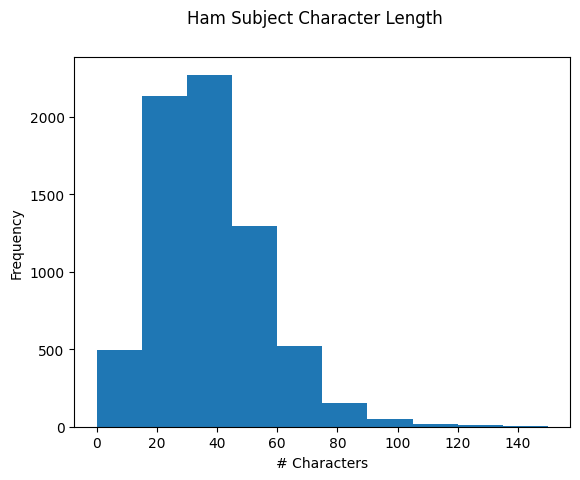

In [19]:
hamhist = Ham_DataFrame["Subject"].str.len().plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Ham Subject Character Length', range=[0, 150])
for ax in hamhist.flatten():
    ax.set_xlabel("# Characters")
    ax.set_ylabel("Frequency")

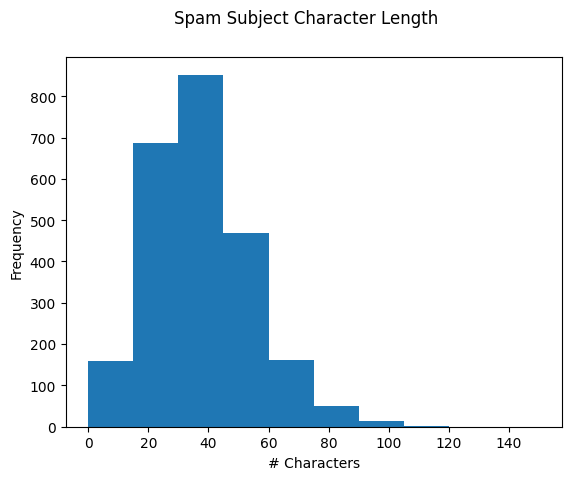

In [20]:
spamhist = Spam_DataFrame["Subject"].str.len().plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Spam Subject Character Length', range=[0, 150])
for ax in spamhist.flatten():
    ax.set_xlabel("# Characters")
    ax.set_ylabel("Frequency")

## Top Non Stopwords in Body Text //Useless

In [21]:
#### Stopwords Function (with modifications) from https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [22]:
def plot_top_non_stopwords_barchart(text):

    extrawords = [">", "-", "—", "face", "nbsp","arial","center","align", "http", "com", "td", "width", "www", "font", "height", "src", "img", "gif", "href", "border", "table", "size", "chart", "bgcolor", "color", "cnet"]

    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(extrawords)
    stop=set(stopwords)


    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y,y=x)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


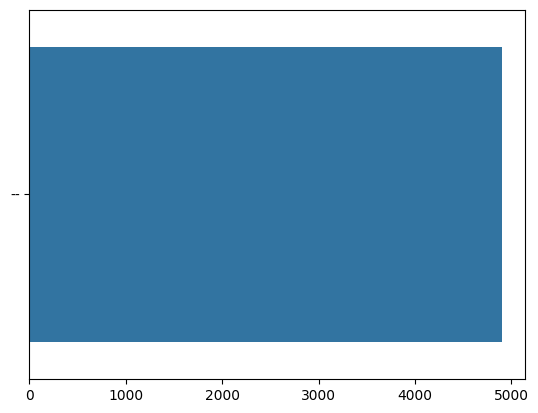

In [24]:
nltk.download('stopwords')
plot_top_non_stopwords_barchart(Ham_DataFrame['Body'])

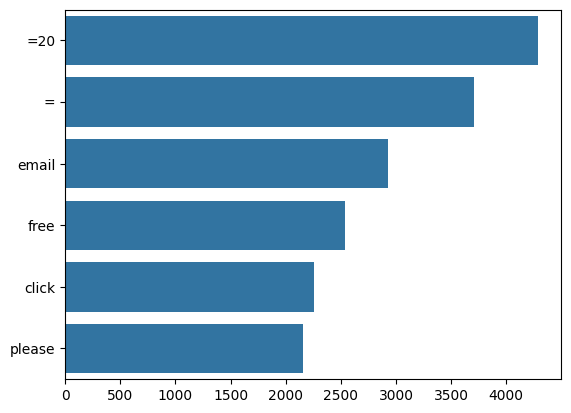

In [25]:
plot_top_non_stopwords_barchart(Spam_DataFrame['Body'])

## Word Length (Average)

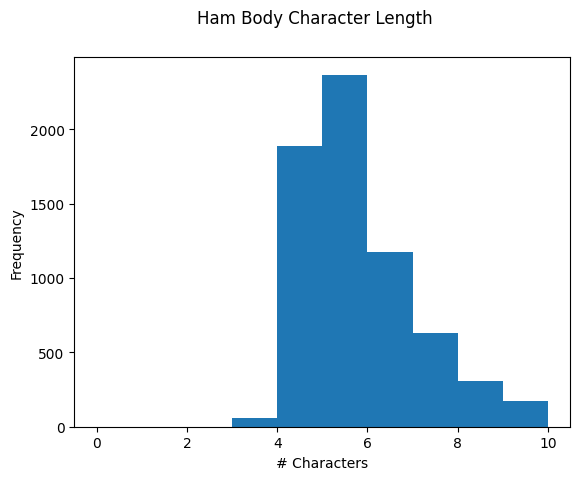

In [32]:
hwordlen = Ham_DataFrame["Body"].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Ham Body Character Length', range=[0, 10])
for ax in hwordlen.flatten():
    ax.set_xlabel("# Characters")
    ax.set_ylabel("Frequency")

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


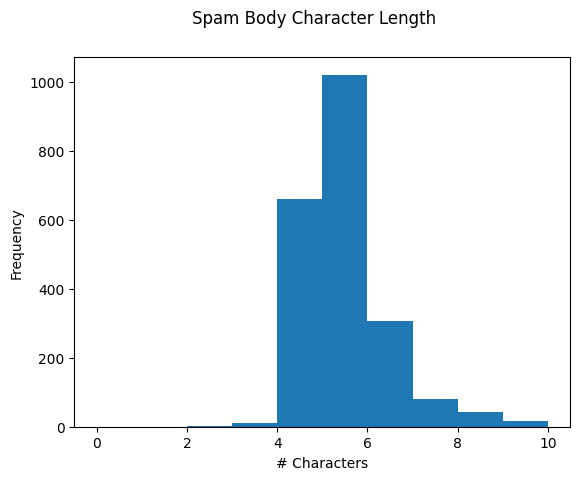

In [33]:
swordlen = Spam_DataFrame["Body"].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Spam Body Character Length', range=[0, 10])
for ax in swordlen.flatten():
    ax.set_xlabel("# Characters")
    ax.set_ylabel("Frequency")


## Word Clouds

In [34]:
#### word clouds funcntion (with modifications) from https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [35]:
def plot_wordcloud(text):

    extrawords = [">", "-", "—", "face", "nbsp","arial","center","align", "http", "com", "td", "width", "www", "font", "height", "src", "img", "gif", "href", "border", "table", "size", "chart", "bgcolor", "color", "cnet"]
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(extrawords)
    stop=set(stopwords)

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus

    corpus=_preprocess_text(text)

    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()



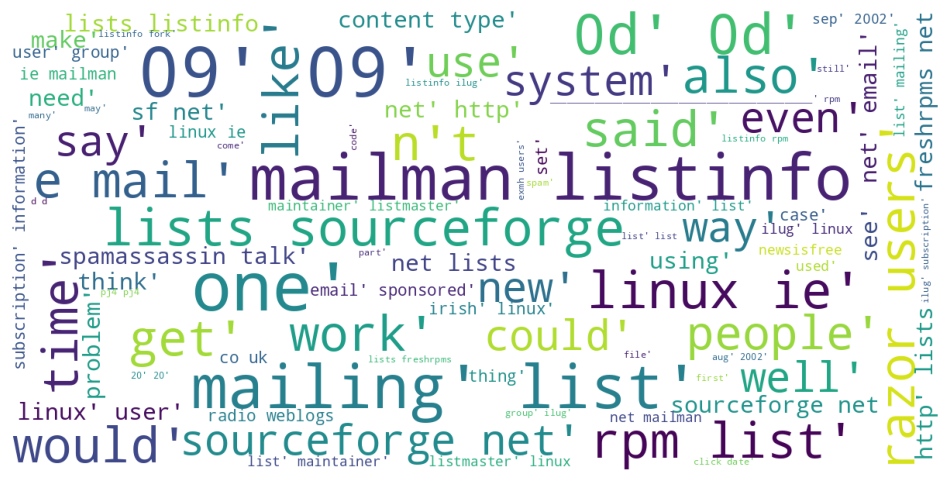

In [36]:
plot_wordcloud(Ham_DataFrame["Body"])

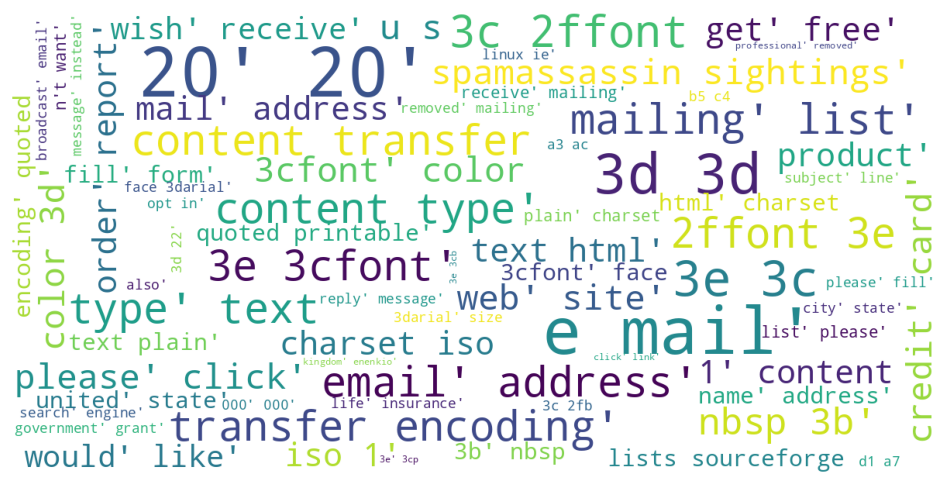

In [37]:
plot_wordcloud(Spam_DataFrame["Body"])

## Top Bigrams in Body Text //Useless

In [38]:
#### Top Bigrams Function from https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [39]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

<ipython-input-40-148514d105e2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y,y=x, palette='GnBu').set(title='Bigram Frequencey (Ham)')


[Text(0.5, 1.0, 'Bigram Frequencey (Ham)')]

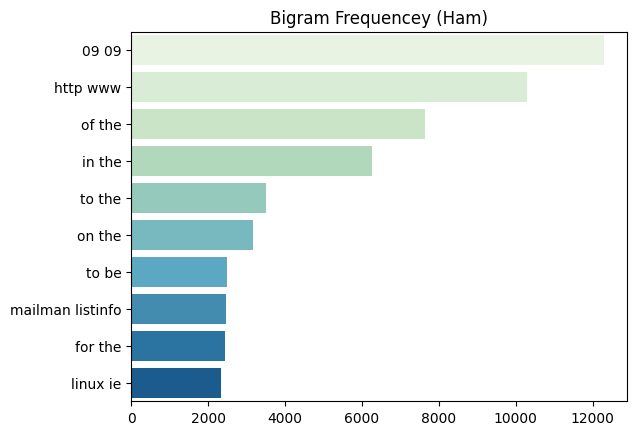

In [40]:
top_n_bigrams = get_top_ngram(Ham_DataFrame["Body"], 2)[:10]
x,y=map(list,zip(*top_n_bigrams))

sns.barplot(x=y,y=x, palette='GnBu').set(title='Bigram Frequencey (Ham)')


<ipython-input-41-da1b8838fae3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y,y=x, palette='GnBu').set(title='Bigram Frequencey (Spam)')


[Text(0.5, 1.0, 'Bigram Frequencey (Spam)')]

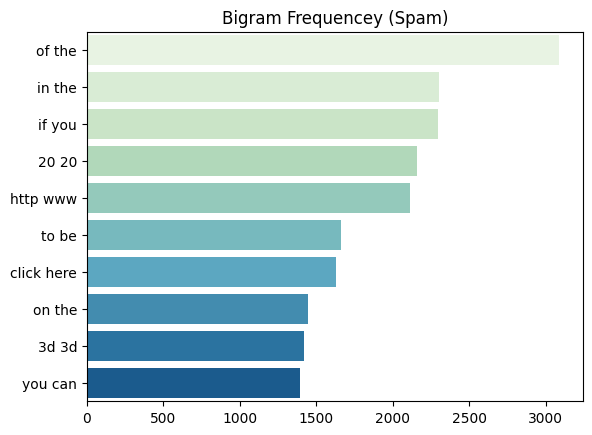

In [41]:
top_n_bigrams = get_top_ngram(Spam_DataFrame["Body"], 2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x, palette='GnBu').set(title='Bigram Frequencey (Spam)')

# ▚▚ Feature Extraction ▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚

## Adding label columns as intrengers for Ham so it can be used in Machine learning algos (encoding)

In [73]:
Ham_DataFrame['label']=1

In [74]:
Ham_DataFrame.head(5)

,From,To,Subject,Body,label
0,the butterfly,exmh-users@spamassassin.taint.org,re: help! i've lost my exmh-unseen window!,in article you write: >>>> patrick salsbury wr...,1
1,aaronsw,yyyy@spamassassin.taint.org,feeling lucky,url: http://www.aaronsw.com/weblog/000609 date...,1
2,bitbitch@magnesium.net,chris olds,re[2]: oh my...,"hello chris, oh i don't know, time-lag synchro...",1
3,"""geege schuman""","""russell turpin"" ,",re: selling wedded bliss (was re: ouch...),intersectedness: i'd be surprised if beberg ev...,1
4,"""gordon mohr""","""mr. fork"" ,",re: dinosaurs eggs and the origins of good and...,neat stuff. seems to combine elements of scien...,1


## Dropping duplicate body values

In [75]:
Ham_DataFrame.shape

(6962, 5)

In [76]:
Ham_data_no_duplicates = Ham_DataFrame.drop_duplicates('Body', keep='last')

In [77]:
Ham_data_no_duplicates.shape

(4307, 5)

## Working on Spam

In [78]:
Spam_Subject = []
Spam_Body = []
Spam_From = []
Spam_To = []
for item in spams:
    Spam_From.append(item[0])
    Spam_To.append(item[1])
    Spam_Subject.append(item[2])
    Spam_Body.append(item[3])

Spam_Dictionary = {"From":Spam_From, "To":Spam_To, "Subject":Spam_Subject, "Body":Spam_Body}
Spam_DataFrame = pd.DataFrame(Spam_Dictionary)
Spam_DataFrame.head() #illustrate spamframe in interactive notebook

,From,To,Subject,Body
0,"""porn p.o.""",yyyy@netnoteinc.com,porn p.o.: your 10 free pictures are here!,"content-type: text/plain; charset=""iso-8859-1""..."
1,"""netprofits""",,100% risk-free way to explosive profits !,"hi jm@netnoteinc.com, are you ready to hear th..."
2,jane thurman,webmaster@efi.ie,email & fax directory $99.95 100 million email...,"future tech international special offer that ""..."
3,bello sankoh,sbello3@caramail.com,confidence,"content-type: text/plain; charset=""iso-8859-1""..."
4,"""us businesses""",,17 mln us businesses on cd ++,we offer a product that will let you develop a...


## Adding label columns as intrengers for Spam so it can be used in Machine learning algos (encoding)

In [79]:
Spam_DataFrame['label']=0

In [80]:
Spam_DataFrame.head(5)

,From,To,Subject,Body,label
0,"""porn p.o.""",yyyy@netnoteinc.com,porn p.o.: your 10 free pictures are here!,"content-type: text/plain; charset=""iso-8859-1""...",0
1,"""netprofits""",,100% risk-free way to explosive profits !,"hi jm@netnoteinc.com, are you ready to hear th...",0
2,jane thurman,webmaster@efi.ie,email & fax directory $99.95 100 million email...,"future tech international special offer that ""...",0
3,bello sankoh,sbello3@caramail.com,confidence,"content-type: text/plain; charset=""iso-8859-1""...",0
4,"""us businesses""",,17 mln us businesses on cd ++,we offer a product that will let you develop a...,0


## dropping duplicate values

In [81]:
Spam_DataFrame.shape

(2399, 5)

In [82]:
data_no_duplicates = Spam_DataFrame.drop_duplicates('Body', keep='last')

In [83]:
data_no_duplicates.shape

(1700, 5)

## adding both data frames of Ham and Spam to get them ready for text processing and feeding to model

In [84]:
result_df = pd.concat([Ham_data_no_duplicates, data_no_duplicates], ignore_index=True)

In [85]:
result_df.head(5)

,From,To,Subject,Body,label
0,"""geege schuman""","""russell turpin"" ,",re: selling wedded bliss (was re: ouch...),intersectedness: i'd be surprised if beberg ev...,1
1,"""geege schuman""","""r. a. hettinga"" , ""geege schuman"" , ""owen byr...",re: comrade communism (was re: crony capitalis...,"first, misattribution. i did not write the blu...",1
2,"""r. a. hettinga""",,re: electric car an edsel...,--- begin forwarded text from: a guy who model...,1
3,"""meltsner, kenneth""","""rohit khare"" ,",re: datapower announces xml-in-silicon,"if it's not stateful, it wouldn't seem to be w...",1
4,"""geege schuman""","""tom"" , ""r. a. hettinga""",re: aa meetings the hottest place to meet wome...,"less obscure haiku buy a puppy, ro! they are c...",1


In [86]:
result_df.tail(5)

,From,To,Subject,Body,label
6002,"""synteligent properties""",ports@freebsd.org,still looking for a house?,my name is jeremy lessaris. i'm looking for in...,0
6003,"""jasjit thomas""",ilug@linux.ie,"[ilug] ilug,bigger, fuller breasts naturally i...",================================= guaranteed t...,0
6004,davrem@btamail.net.cn,dpreware@netnoir.net,email marketing info,untitled would you like to advertise your webs...,0
6005,susan_kamachi@lycos.com,,[ilug] want to play poker with other people on...,get your favorite poker action at http://www.m...,0
6006,ellebt@hotmail.com,", , , , , , , ,",re: ink prices got you down? 11956,would you like to save up to 80 would you like...,0


In [87]:
result_df.shape

(6007, 5)

## Adding an additinal column for the lenghth of the body this will serve as feature in our models

In [88]:
result_df['text-length'] = result_df['Body'].str.len()
result_df.head(5)

,From,To,Subject,Body,label,text-length
0,"""geege schuman""","""russell turpin"" ,",re: selling wedded bliss (was re: ouch...),intersectedness: i'd be surprised if beberg ev...,1,747
1,"""geege schuman""","""r. a. hettinga"" , ""geege schuman"" , ""owen byr...",re: comrade communism (was re: crony capitalis...,"first, misattribution. i did not write the blu...",1,7039
2,"""r. a. hettinga""",,re: electric car an edsel...,--- begin forwarded text from: a guy who model...,1,3395
3,"""meltsner, kenneth""","""rohit khare"" ,",re: datapower announces xml-in-silicon,"if it's not stateful, it wouldn't seem to be w...",1,21133
4,"""geege schuman""","""tom"" , ""r. a. hettinga""",re: aa meetings the hottest place to meet wome...,"less obscure haiku buy a puppy, ro! they are c...",1,1297


##  Adding an additinal column for the number of punctuations used this will serve as features in our models

In [89]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [90]:
def count_punctuations(text):
    return sum(1 for char in text if char in string.punctuation)

# Add a new column 'PunctuationCount' containing the number of punctuations in body
result_df['Punctuation_Count'] = result_df['Body'].apply(count_punctuations)



In [91]:
result_df.head(5)

,From,To,Subject,Body,label,text-length,Punctuation_Count
0,"""geege schuman""","""russell turpin"" ,",re: selling wedded bliss (was re: ouch...),intersectedness: i'd be surprised if beberg ev...,1,747,130
1,"""geege schuman""","""r. a. hettinga"" , ""geege schuman"" , ""owen byr...",re: comrade communism (was re: crony capitalis...,"first, misattribution. i did not write the blu...",1,7039,446
2,"""r. a. hettinga""",,re: electric car an edsel...,--- begin forwarded text from: a guy who model...,1,3395,318
3,"""meltsner, kenneth""","""rohit khare"" ,",re: datapower announces xml-in-silicon,"if it's not stateful, it wouldn't seem to be w...",1,21133,1435
4,"""geege schuman""","""tom"" , ""r. a. hettinga""",re: aa meetings the hottest place to meet wome...,"less obscure haiku buy a puppy, ro! they are c...",1,1297,95


## examining the data for some anamoly detection

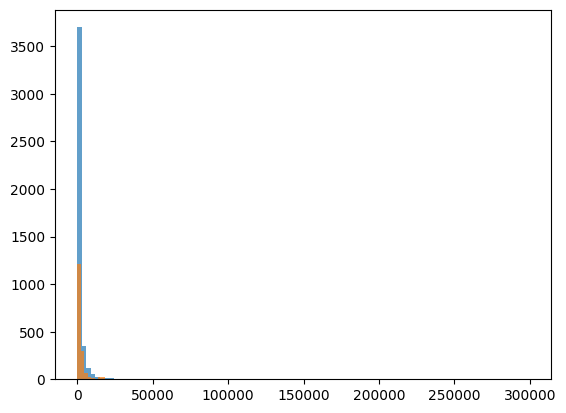

In [92]:
plt.hist(result_df[result_df['label'] == 1]['text-length'], bins = 100, alpha = 0.7, label='Ham')
plt.hist(result_df[result_df['label'] == 0]['text-length'], bins = 100, alpha = 0.7, label='Spam')
plt.show()


In [93]:
## Unusual spike around the number of words lets examine

In [94]:
df_sorted = result_df.sort_values(by='text-length')

In [95]:
df_sorted.tail(5)

,From,To,Subject,Body,label,text-length,Punctuation_Count
2129,"""blo.gs""",zzz@example.com,updated weblogs from blo.gs,change your settings: http://blo.gs/settings.p...,1,163472,23206
5960,freeidd@dogma.slashnull.org,"hong.kong.commercial@dogma.slashnull.org, hk01...",=?big5?q?=a7k=b6o=b5l=ad=ad=a6=b8=a5=f4=a5=b4=...,content-type: multipart/alternative; boundary=...,0,183957,5581
210,none,none,none,mv 00001.7c53336b37003a9286aba55d2945844c 0000...,1,202500,5000
5844,"""adverting department""","""zzzz@jmason.org""",may i have a moment of your time please,content-type: multipart/alternative; boundary=...,0,230685,4481
2151,"""=?iso-2022-jp?b?gyrcmetfbcehp04bkei=?=""","""=?iso-2022-jp?b?jxskqiuijualycemjvklcyu4jwmlx...",=?iso-2022-jp?b?gyrcrnxlxdhsje43b0w+iuolnsvwjt...,"content-type: text/plain; charset=""iso-2022-jp...",1,298977,168982


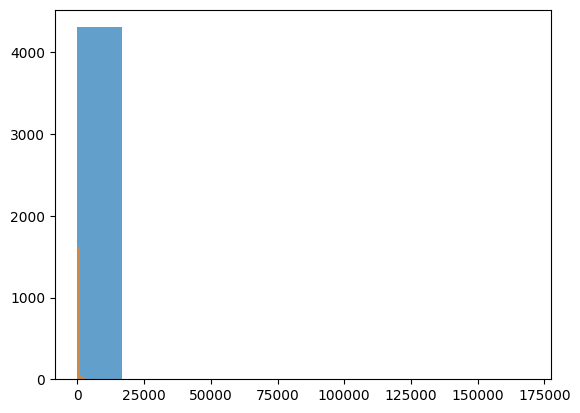

In [96]:
plt.hist(result_df[result_df['label'] == 1]['Punctuation_Count'], bins = 10, alpha = 0.7, label='Ham')
plt.hist(result_df[result_df['label'] == 0]['Punctuation_Count'], bins = 10, alpha = 0.7, label='Spam')
plt.show()

In [97]:
numerical_columns=result_df.select_dtypes(include=[np.number])

<Axes: >

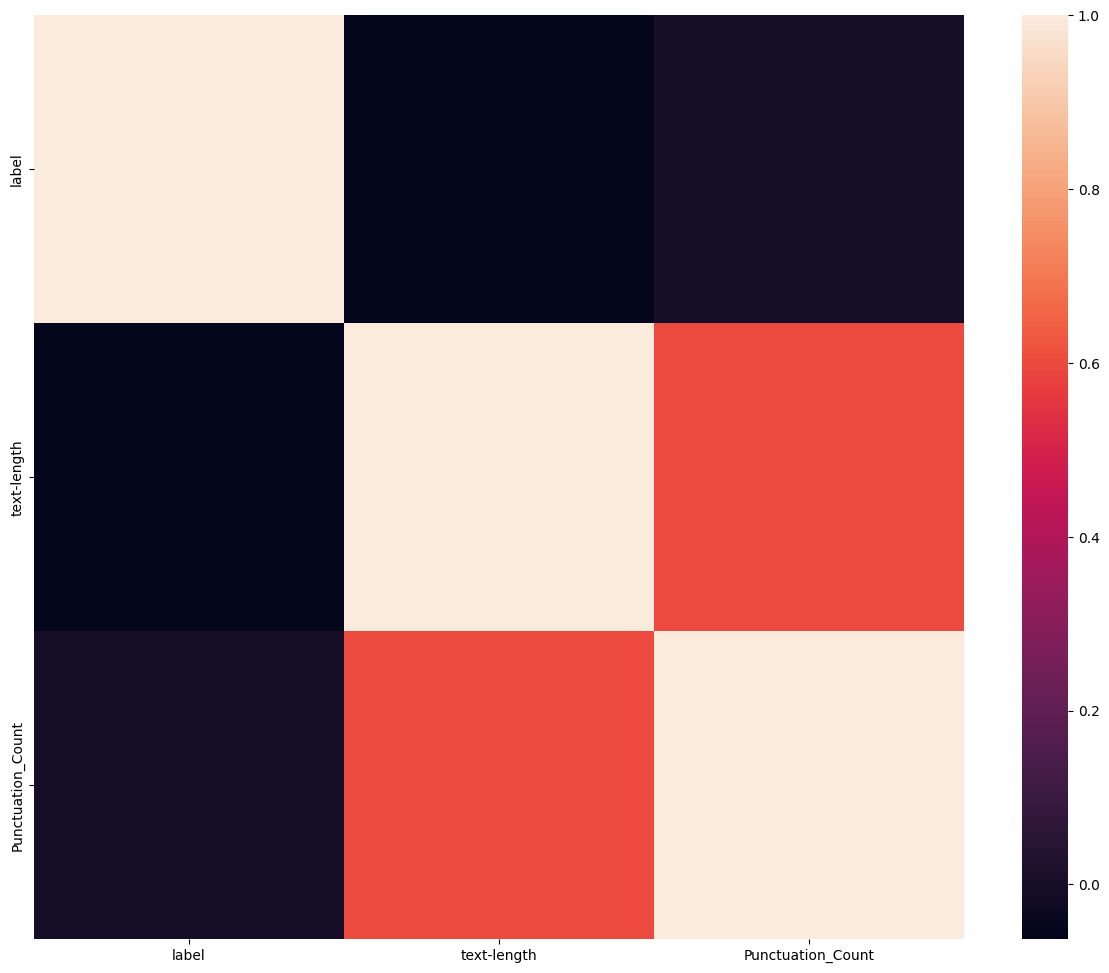

In [98]:
correlation = numerical_columns.corr()
plt.figure(figsize = (15, 12))
sns.heatmap(correlation)

## As we can see there seem to be no relationship between the lengths and the labels

In [99]:
print(correlation['label'].sort_values(ascending = False))

label                1.000000
Punctuation_Count   -0.001065
text-length         -0.063026
Name: label, dtype: float64


## Getting Data ready for our models by doing the below steps



*   Removing Punctuations
*   Tokenization
*   Removing Stopwords
*   Stemming
*   Lemmatization








In [100]:
nltk.download('stopwords')

from nltk.corpus import stopwords
stopwords.words('english')[0:10] # Show some stop words



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [101]:

from nltk.stem.lancaster import LancasterStemmer
import string

stemmer = LancasterStemmer()
wn = nltk.WordNetLemmatizer()

def process(text):

    stopwordList = stopwords.words('english')
    extrawords = [">", "-", "—", "face", "nbsp","arial","center","align", "http", "com", "td", "width", "www", "font", "height", "src", "img", "gif", "href", "border", "table", "size", "chart", "bgcolor", "color", "cnet"]
    stopwordList.extend(extrawords)
    stop=set(stopwordList)

    # Removing Punctuations
    # Check characters to see if they are in punctuation

    text1 = [char for char in text if char not in string.punctuation]
     # Join the characters again to form the string.
    text1 = ''.join(text)

    #Tokenization
    words = nltk.word_tokenize(text1)

    #Removing Stopwords
    words = [t for t in words if t not in stop]

    #Stemming
    words = [stemmer.stem(w.lower()) for w in words]


    #Lemmatization

    words = [wn.lemmatize(w) for w in words]


    return words

In [102]:
result_df['AllText'] = result_df['From'] + ' ' + result_df['To'] + ' ' + result_df['Subject']+ ' ' + result_df['Body']


In [103]:
result_df.head(5)

,From,To,Subject,Body,label,text-length,Punctuation_Count,AllText
0,"""geege schuman""","""russell turpin"" ,",re: selling wedded bliss (was re: ouch...),intersectedness: i'd be surprised if beberg ev...,1,747,130,"""geege schuman"" ""russell turpin"" , re: selli..."
1,"""geege schuman""","""r. a. hettinga"" , ""geege schuman"" , ""owen byr...",re: comrade communism (was re: crony capitalis...,"first, misattribution. i did not write the blu...",1,7039,446,"""geege schuman"" ""r. a. hettinga"" , ""geege sch..."
2,"""r. a. hettinga""",,re: electric car an edsel...,--- begin forwarded text from: a guy who model...,1,3395,318,"""r. a. hettinga"" re: electric car an edsel....."
3,"""meltsner, kenneth""","""rohit khare"" ,",re: datapower announces xml-in-silicon,"if it's not stateful, it wouldn't seem to be w...",1,21133,1435,"""meltsner, kenneth"" ""rohit khare"" , re: data..."
4,"""geege schuman""","""tom"" , ""r. a. hettinga""",re: aa meetings the hottest place to meet wome...,"less obscure haiku buy a puppy, ro! they are c...",1,1297,95,"""geege schuman"" ""tom"" , ""r. a. hettinga"" re:..."


# ▚▚ Modeling ▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚

## Create a pipeline that will use countVectorizer with the function

In [104]:
result_df['AllText'].apply(process)

0       [``, geeg, schuman, '', ``, russel, turpin, ''...
1       [``, geeg, schuman, '', ``, r., a., hetting, '...
2       [``, r., a., hetting, '', :, elect, car, edsel...
3       [``, meltsn, ,, kenne, '', ``, rohit, khar, ''...
4       [``, geeg, schuman, '', ``, tom, '', ,, ``, r....
                              ...                        
6002    [``, syntelig, property, '', port, @, freebsd....
6003    [``, jasjit, thoma, '', ilug, @, linux.ie, [, ...
6004    [davrem, @, btamail.net.cn, dpreware, @, netno...
6005    [susan_kamachi, @, lycos.com, [, ilug, ], want...
6006    [ellebt, @, hotmail.com, ,, ,, ,, ,, ,, ,, ,, ...
Name: AllText, Length: 6007, dtype: object

In [105]:
from sklearn.feature_extraction.text import CountVectorizer
transformer = CountVectorizer(analyzer=process).fit(result_df['AllText'])
print(len(transformer.vocabulary_))

100038


## Making BOW

In [106]:
data2 = transformer.transform(result_df['AllText'])

## Exmaple

In [107]:
message3 = result_df['AllText'][2]
print(message3)
bow3 = transformer.transform([message3])
print(bow3)
print(bow3.shape)

"r. a. hettinga"   re: electric car an edsel... --- begin forwarded text from: a guy who models plasma all day... to: "r. a. hettinga" subject: re: electric car an edsel... date: tue, 3 sep 2002 22:49:20 -0600 bob, this capacitor drive idea isn't completely stupid, but neither is it well thought out. maxwell (www.maxwell.com) makes and sells high energy density capacitors, called ultracapacitors. they deliver them in an air-cooled, voltage regulated module that will charge to 42 v and hold 128 kilojoules -- roughly the energy in 2 teaspoons of sugar or a bite of a donut -- and weighs 16 kilograms. if that electrical energy could all be converted to kinetic energy, there's enough to get the capacitor module up to about 200 mph -- in a vacuum. suppose you take the entire power density of the capacitor module -- 2.8 kw/kg (~4 hp/kg!) -- and punch it through an electric motor. how much does the 64 hp electric motor weigh? if it were as little as 50 kg -- and i bet it isn't -- that capacito

In [108]:
print(transformer.get_feature_names_out()[16])

'-type


In [109]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(data2)
data_tfidf = tfidf_transformer.transform(data2)
print(data_tfidf.shape)

(6007, 100038)


In [110]:
data_tfidf

<6007x100038 sparse matrix of type '<class 'numpy.float64'>'
	with 812225 stored elements in Compressed Sparse Row format>

In [111]:
from sklearn.model_selection import train_test_split

X = result_df.drop(columns=['label'])
msg_train, msg_test, label_train, label_test =  train_test_split(result_df['AllText'], result_df['label'], test_size=0.3, shuffle = True)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))



X = result_df.drop(columns=['label'])
y = result_df.drop(columns=['AllText', 'text-length'])

X_tarin, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)

print(len(X_tarin), len(X_test), len(y_train) , len(y_test))

4204 1803 6007
4805 1202 4805 1202


In [112]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(data_tfidf, result_df['label'])

all_predictions = model.predict(data_tfidf)
print(all_predictions)

[1 1 1 ... 0 1 0]


## Training and Testing a Naive Bayes/MultinomialNB

In [113]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
], verbose=3)

## Fit the pipeline and then perform prediction

In [114]:
pipeline.fit(msg_train,label_train)

[Pipeline] ............... (step 1 of 3) Processing bow, total=  35.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function process at 0x7f2b1c16dd80>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())],
         verbose=3)

# Results and Predictions

In [115]:
predictions = pipeline.predict(msg_test)

In [116]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(label_test, predictions))


[[ 172  309]
 [   2 1320]]


In [117]:

tn, fp, fn, tp = confusion_matrix(label_test, predictions).ravel()
tn, fp, fn, tp



(172, 309, 2, 1320)

In [118]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.36      0.53       481
           1       0.81      1.00      0.89      1322

    accuracy                           0.83      1803
   macro avg       0.90      0.68      0.71      1803
weighted avg       0.86      0.83      0.80      1803



This is a dictionary for storing all confusion matrices

In [119]:
conf_mats = {}

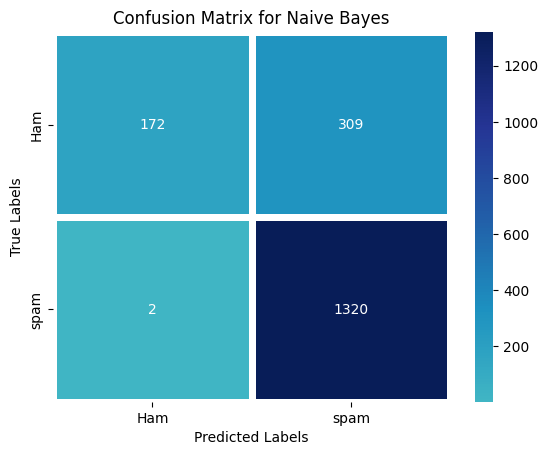

In [120]:
conf_mat = confusion_matrix(label_test, predictions)
conf_mats['Naive Bayes'] = conf_mat

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,cmap="YlGnBu",center=0, fmt="d")

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion Matrix for Naive Bayes')
ax.xaxis.set_ticklabels(['Ham','spam'])
ax.yaxis.set_ticklabels(['Ham','spam'])
plt.show()

In [121]:
NBAccuracy =round(accuracy_score(label_test, predictions),5)

In [122]:
print(NBAccuracy)

0.82751


## Training and Testing a Deep Neural Network

In [123]:
from sklearn.neural_network import MLPClassifier

In [124]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,4), random_state=0, early_stopping=True, verbose=2)),  # train on TF-IDF vectors w/ MLPClassifier classifier with two hidden layers
])

In [125]:
pipeline.fit(msg_train,label_train)

Iteration 1, loss = 0.65211036
Validation score: 0.935867
Iteration 2, loss = 0.37558181
Validation score: 0.938242
Iteration 3, loss = 0.23434135
Validation score: 0.945368
Iteration 4, loss = 0.18063960
Validation score: 0.957245
Iteration 5, loss = 0.15754251
Validation score: 0.954869
Iteration 6, loss = 0.14550229
Validation score: 0.954869
Iteration 7, loss = 0.13821422
Validation score: 0.950119
Iteration 8, loss = 0.13324766
Validation score: 0.947743
Iteration 9, loss = 0.12943702
Validation score: 0.942993
Iteration 10, loss = 0.12633906
Validation score: 0.942993
Iteration 11, loss = 0.12361849
Validation score: 0.942993
Iteration 12, loss = 0.12125474
Validation score: 0.942993
Iteration 13, loss = 0.11902796
Validation score: 0.942993
Iteration 14, loss = 0.11694930
Validation score: 0.942993
Iteration 15, loss = 0.11501366
Validation score: 0.940618
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function process at 0x7f2b1c16dd80>)),
                ('tfidf', TfidfTransformer()),
                ('classifier',
                 MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 4),
                               random_state=0, verbose=2))])

In [126]:
predictions = pipeline.predict(msg_test)

In [127]:
print(confusion_matrix(label_test, predictions))

[[ 412   69]
 [   5 1317]]


In [128]:
tn, fp, fn, tp = confusion_matrix(label_test, predictions).ravel()
tn, fp, fn, tp

(412, 69, 5, 1317)

In [129]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92       481
           1       0.95      1.00      0.97      1322

    accuracy                           0.96      1803
   macro avg       0.97      0.93      0.95      1803
weighted avg       0.96      0.96      0.96      1803



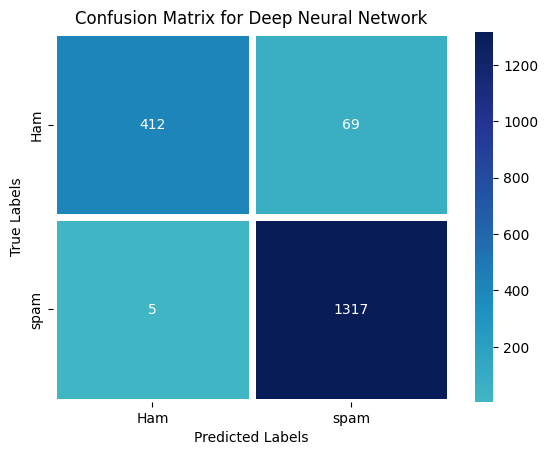

In [130]:
conf_mat = confusion_matrix(label_test, predictions)
conf_mats['Deep Neural Network'] = conf_mat

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,cmap="YlGnBu",center=0, fmt="d")

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion Matrix for Deep Neural Network')
ax.xaxis.set_ticklabels(['Ham','spam'])
ax.yaxis.set_ticklabels(['Ham','spam'])
plt.show()

In [131]:
DNNAccuracy =round(accuracy_score(label_test, predictions),5)

In [132]:
print(DNNAccuracy)

0.95896


## Support Vector Machine

In [133]:
# Model

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svc = SVC(kernel='sigmoid', gamma=1.0)
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', svc),  # train on TF-IDF vectors w/ MLPClassifier classifier with two hidden layers
])



In [134]:
pipeline.fit(msg_train,label_train)


Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function process at 0x7f2b1c16dd80>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', SVC(gamma=1.0, kernel='sigmoid'))])

In [135]:
predictions = pipeline.predict(msg_test)

In [136]:
print(confusion_matrix(label_test, predictions))

[[ 458   23]
 [  35 1287]]


In [137]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       481
           1       0.98      0.97      0.98      1322

    accuracy                           0.97      1803
   macro avg       0.96      0.96      0.96      1803
weighted avg       0.97      0.97      0.97      1803



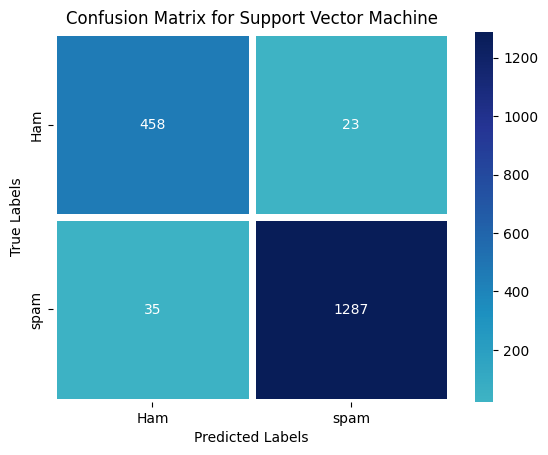

In [138]:
conf_mat = confusion_matrix(label_test, predictions)
conf_mats['SVM'] = conf_mat

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,cmap="YlGnBu",center=0, fmt="d")

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion Matrix for Support Vector Machine')
ax.xaxis.set_ticklabels(['Ham','spam'])
ax.yaxis.set_ticklabels(['Ham','spam'])
plt.show()

In [139]:
SVMAccuracy =round(accuracy_score(label_test, predictions),5)

In [140]:
print(SVMAccuracy)

0.96783


##Random Forest

In [141]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs=-1)
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', rf),  # train on TF-IDF vectors w/ MLPClassifier classifier with two hidden layers
])




In [142]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function process at 0x7f2b1c16dd80>)),
                ('tfidf', TfidfTransformer()),
                ('classifier',
                 RandomForestClassifier(max_depth=20, n_estimators=50,
                                        n_jobs=-1))])

In [143]:
predictions = pipeline.predict(msg_test)

In [144]:
print(confusion_matrix(label_test, predictions))

[[ 367  114]
 [   4 1318]]


In [145]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86       481
           1       0.92      1.00      0.96      1322

    accuracy                           0.93      1803
   macro avg       0.95      0.88      0.91      1803
weighted avg       0.94      0.93      0.93      1803



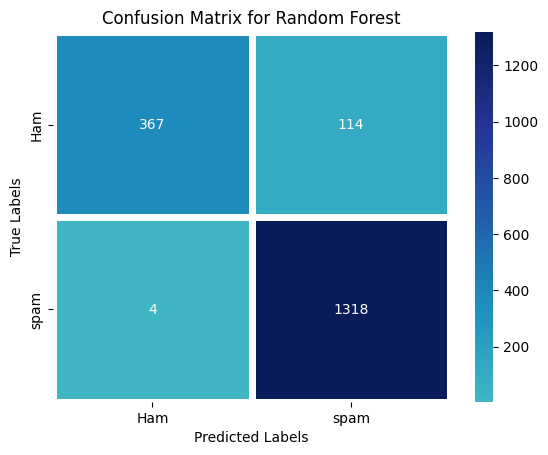

In [146]:
conf_mat = confusion_matrix(label_test, predictions)
conf_mats['Random Forest'] = conf_mat

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,cmap="YlGnBu",center=0, fmt="d")

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion Matrix for Random Forest')
ax.xaxis.set_ticklabels(['Ham','spam'])
ax.yaxis.set_ticklabels(['Ham','spam'])
plt.show()

In [147]:
RandomForestAccuracy =round(accuracy_score(label_test, predictions),5)

In [148]:
print(RandomForestAccuracy)

0.93455


## Logistic Regression

In [149]:
from sklearn.linear_model import LinearRegression, LogisticRegression

logisticRegr = LogisticRegression()
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', logisticRegr),  # train on TF-IDF vectors w/ MLPClassifier classifier with two hidden layers
])



In [150]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function process at 0x7f2b1c16dd80>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', LogisticRegression())])

In [151]:
predictions = pipeline.predict(msg_test)

In [152]:
print(confusion_matrix(label_test, predictions))

[[ 445   36]
 [  17 1305]]


In [153]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       481
           1       0.97      0.99      0.98      1322

    accuracy                           0.97      1803
   macro avg       0.97      0.96      0.96      1803
weighted avg       0.97      0.97      0.97      1803



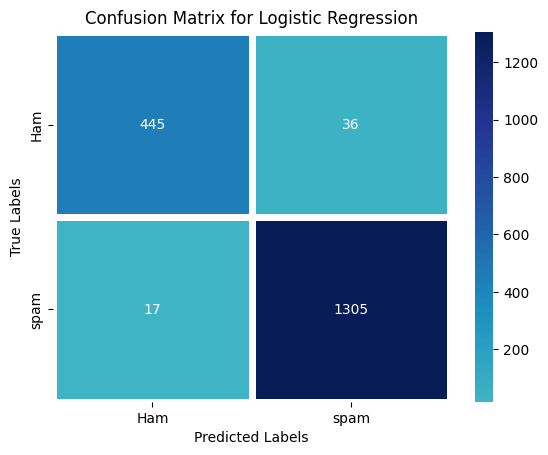

In [154]:
conf_mat = confusion_matrix(label_test, predictions)
conf_mats['Logistic Regression'] = conf_mat

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,cmap="YlGnBu",center=0, fmt="d")

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion Matrix for Logistic Regression')
ax.xaxis.set_ticklabels(['Ham','spam'])
ax.yaxis.set_ticklabels(['Ham','spam'])
plt.show()

In [155]:
LogisticAccuracy =round(accuracy_score(label_test, predictions),5)

In [156]:
print(LogisticAccuracy)

0.9706


## KNearest Neighbors

In [157]:
from sklearn.neighbors import KNeighborsClassifier


clf = KNeighborsClassifier(n_neighbors=149, weights='uniform', algorithm='auto', p=1,metric='euclidean', n_jobs=-1)
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', clf),  # train on TF-IDF vectors w/ MLPClassifier classifier with two hidden layers
])


In [158]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function process at 0x7f2b1c16dd80>)),
                ('tfidf', TfidfTransformer()),
                ('classifier',
                 KNeighborsClassifier(metric='euclidean', n_jobs=-1,
                                      n_neighbors=149, p=1))])

In [159]:
predictions = pipeline.predict(msg_test)

In [160]:
print(confusion_matrix(label_test, predictions))

[[ 315  166]
 [  66 1256]]


In [161]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.65      0.73       481
           1       0.88      0.95      0.92      1322

    accuracy                           0.87      1803
   macro avg       0.86      0.80      0.82      1803
weighted avg       0.87      0.87      0.87      1803



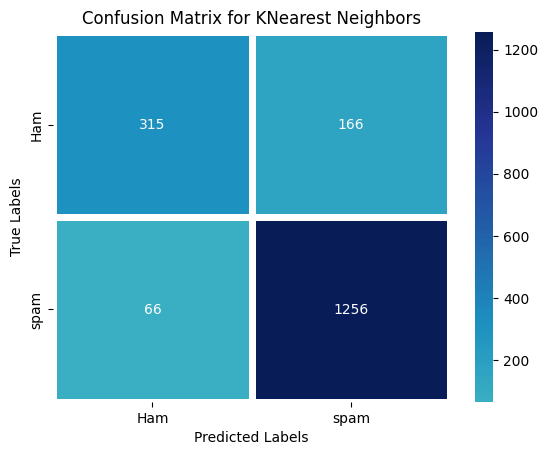

In [162]:
conf_mat = confusion_matrix(label_test, predictions)
conf_mats['KNN'] = conf_mat

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,cmap="YlGnBu",center=0, fmt="d")

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion Matrix for KNearest Neighbors')
ax.xaxis.set_ticklabels(['Ham','spam'])
ax.yaxis.set_ticklabels(['Ham','spam'])
plt.show()

In [163]:
KNearest =round(accuracy_score(label_test, predictions),5)

In [164]:
print(KNearest)

0.87133


## Would be nice to have a comparison of all models here in a visual format

<ipython-input-165-e1c4f5848ca3>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  gr=sns.barplot(x='Model', y='Accuracy', data=data,palette="GnBu")


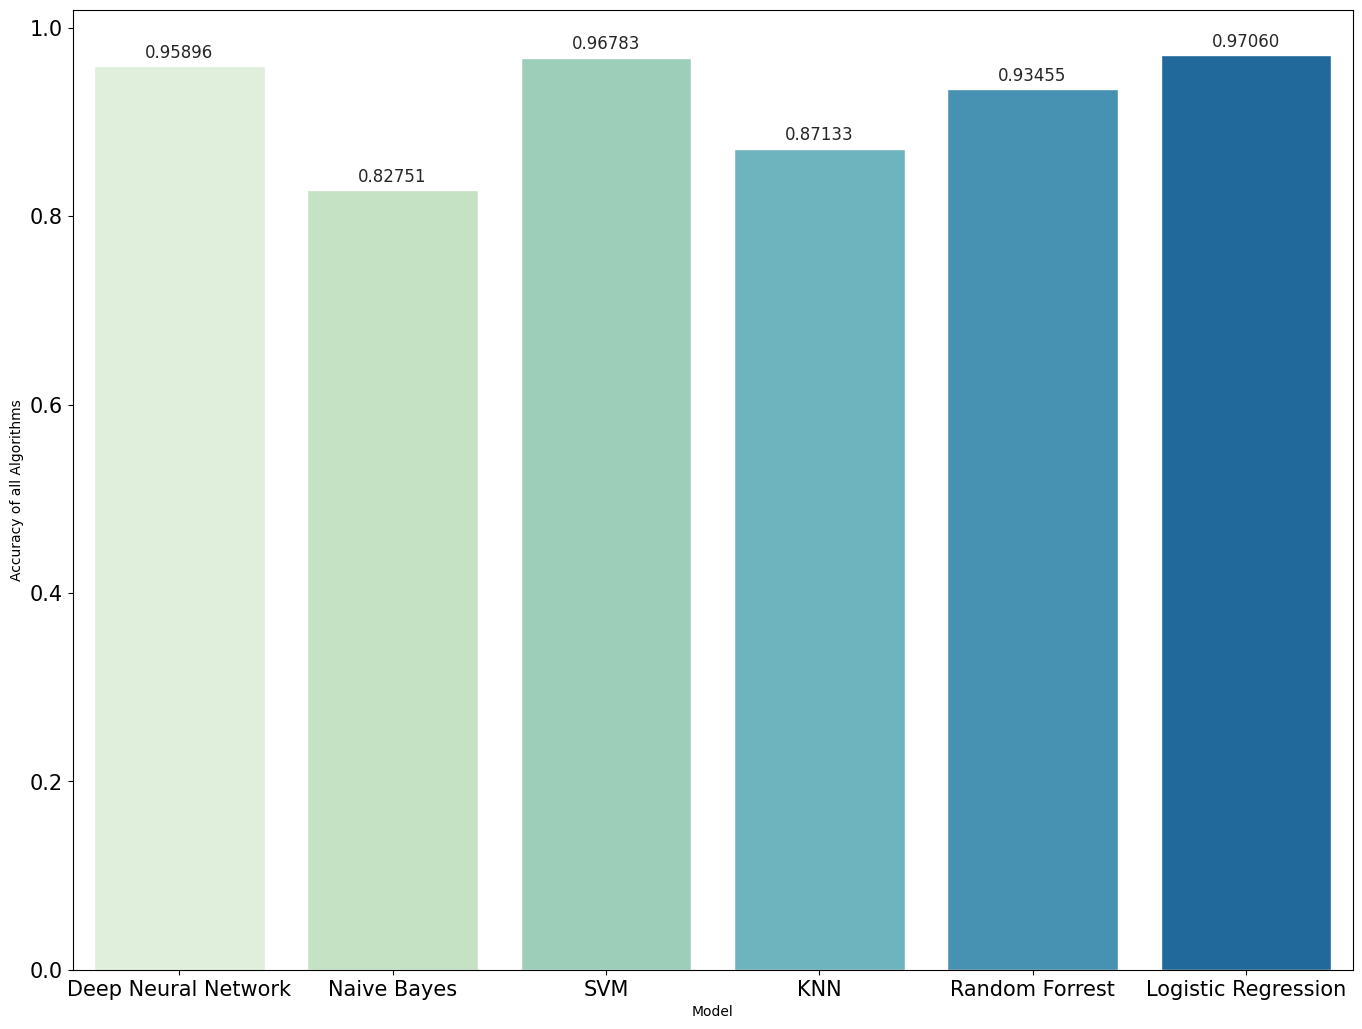

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([1,1,2,2]);


data = {'Model' : ['Deep Neural Network', 'Naive Bayes', 'SVM', 'KNN', 'Random Forrest', 'Logistic Regression'],
        'Accuracy' : [DNNAccuracy,NBAccuracy,SVMAccuracy,KNearest,RandomForestAccuracy,LogisticAccuracy]}
sns.set(style="whitegrid")
gr=sns.barplot(x='Model', y='Accuracy', data=data,palette="GnBu")
ax.set_ylabel("Accuracy of all Algorithms")
ax.tick_params(labelsize=15)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.5f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

plt.show()

# While we're here let's see all that precision, recall, and F1 scores

{'Naive Bayes': array([[ 172,  309],
       [   2, 1320]]), 'Deep Neural Network': array([[ 412,   69],
       [   5, 1317]]), 'SVM': array([[ 458,   23],
       [  35, 1287]]), 'Random Forest': array([[ 367,  114],
       [   4, 1318]]), 'Logistic Regression': array([[ 445,   36],
       [  17, 1305]]), 'KNN': array([[ 315,  166],
       [  66, 1256]])}
{'Prec_H': [0.9885057471264368, 0.988009592326139, 0.9290060851926978, 0.9892183288409704, 0.9632034632034632, 0.8267716535433071], 'Prec_S': [0.8103130755064457, 0.9502164502164502, 0.982442748091603, 0.9203910614525139, 0.9731543624161074, 0.8832630098452883], 'Rec_H': [0.3575883575883576, 0.8565488565488566, 0.9521829521829522, 0.762993762993763, 0.9251559251559252, 0.6548856548856549], 'Rec_S': [0.9984871406959153, 0.9962178517397882, 0.9735249621785174, 0.9969742813918305, 0.9871406959152799, 0.9500756429652042], 'F1_H': [0.5251908396946564, 0.9175946547884187, 0.9404517453798769, 0.8615023474178404, 0.943796394485684, 0.730858468

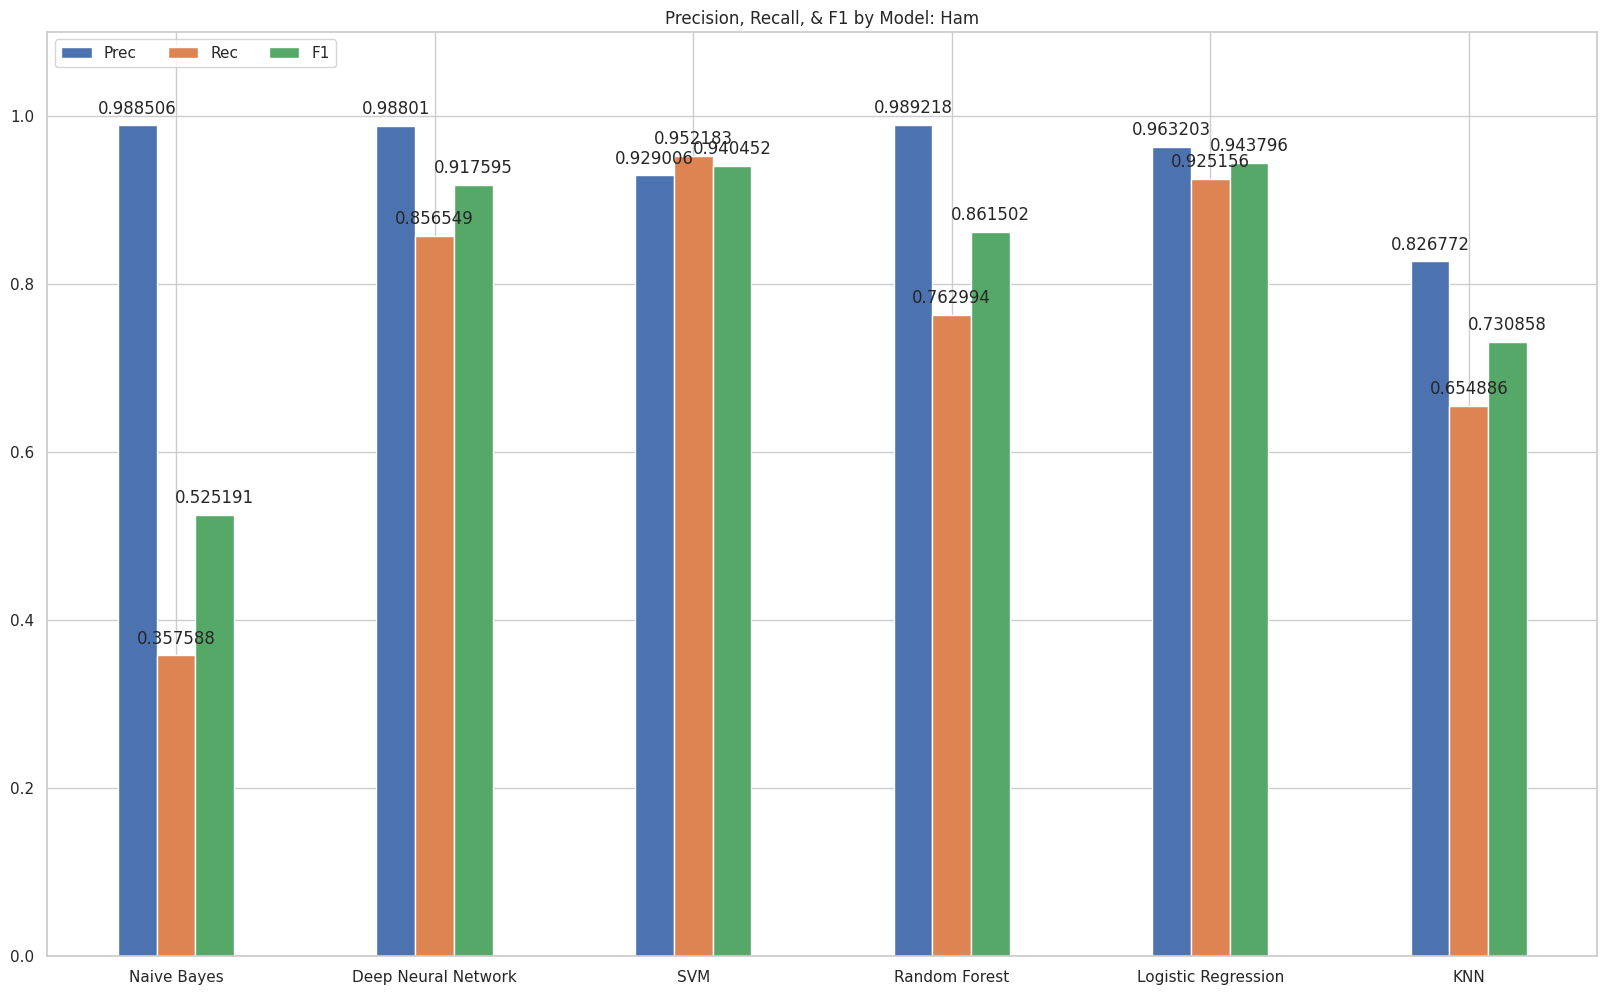

In [187]:
score_calcs = {
    "Prec_H":[],
    "Prec_S":[],
    "Rec_H":[],
    "Rec_S":[],
    "F1_H":[],
    "F1_S":[]
}

# Organise Calculations
models = conf_mats.keys()
for model in models:
  mat = conf_mats[model]
  # Do Precision Equation for Spam and Ham; P = TP / (TP + FP)
  Prec_h = mat[0][0] / (mat[0][0] + mat[1][0])
  score_calcs["Prec_H"].append(Prec_h)
  Prec_s = mat[1][1] / (mat[0][1] + mat[1][1])
  score_calcs["Prec_S"].append(Prec_s)
  # Do Recall Equation; R = TP / (TP + FN)
  Rec_h = mat[0][0] / (mat[0][0] + mat[0][1])
  score_calcs["Rec_H"].append(Rec_h)
  Rec_s = mat[1][1] / (mat[1][0] + mat[1][1])
  score_calcs["Rec_S"].append(Rec_s)
  # Do F1; F1 = 2PR / (P + R)
  score_calcs["F1_H"].append(2 * Prec_h * Rec_h / (Prec_h + Rec_h))
  score_calcs["F1_S"].append(2 * Prec_s * Rec_s / (Prec_s + Rec_s))

# Display Ham
fig, ax = plt.subplots()
fig.set_size_inches(20, 12)

x = np.arange(len(conf_mats.keys()))
width = 0.15
i = 0
for k, v in score_calcs.items():
  if k[-1] == 'H':
    offset = width * i
    rects = ax.bar(x + offset, v, width, label=k[:-2])
    ax.bar_label(rects, padding=6)
    i+=1

ax.set_title('Precision, Recall, & F1 by Model: Ham')
ax.set_xticks(x + width, models)
ax.legend(loc='upper left', ncols=6)
ax.set_ylim(0, 1.1)


plt.show()

(0.0, 1.1)

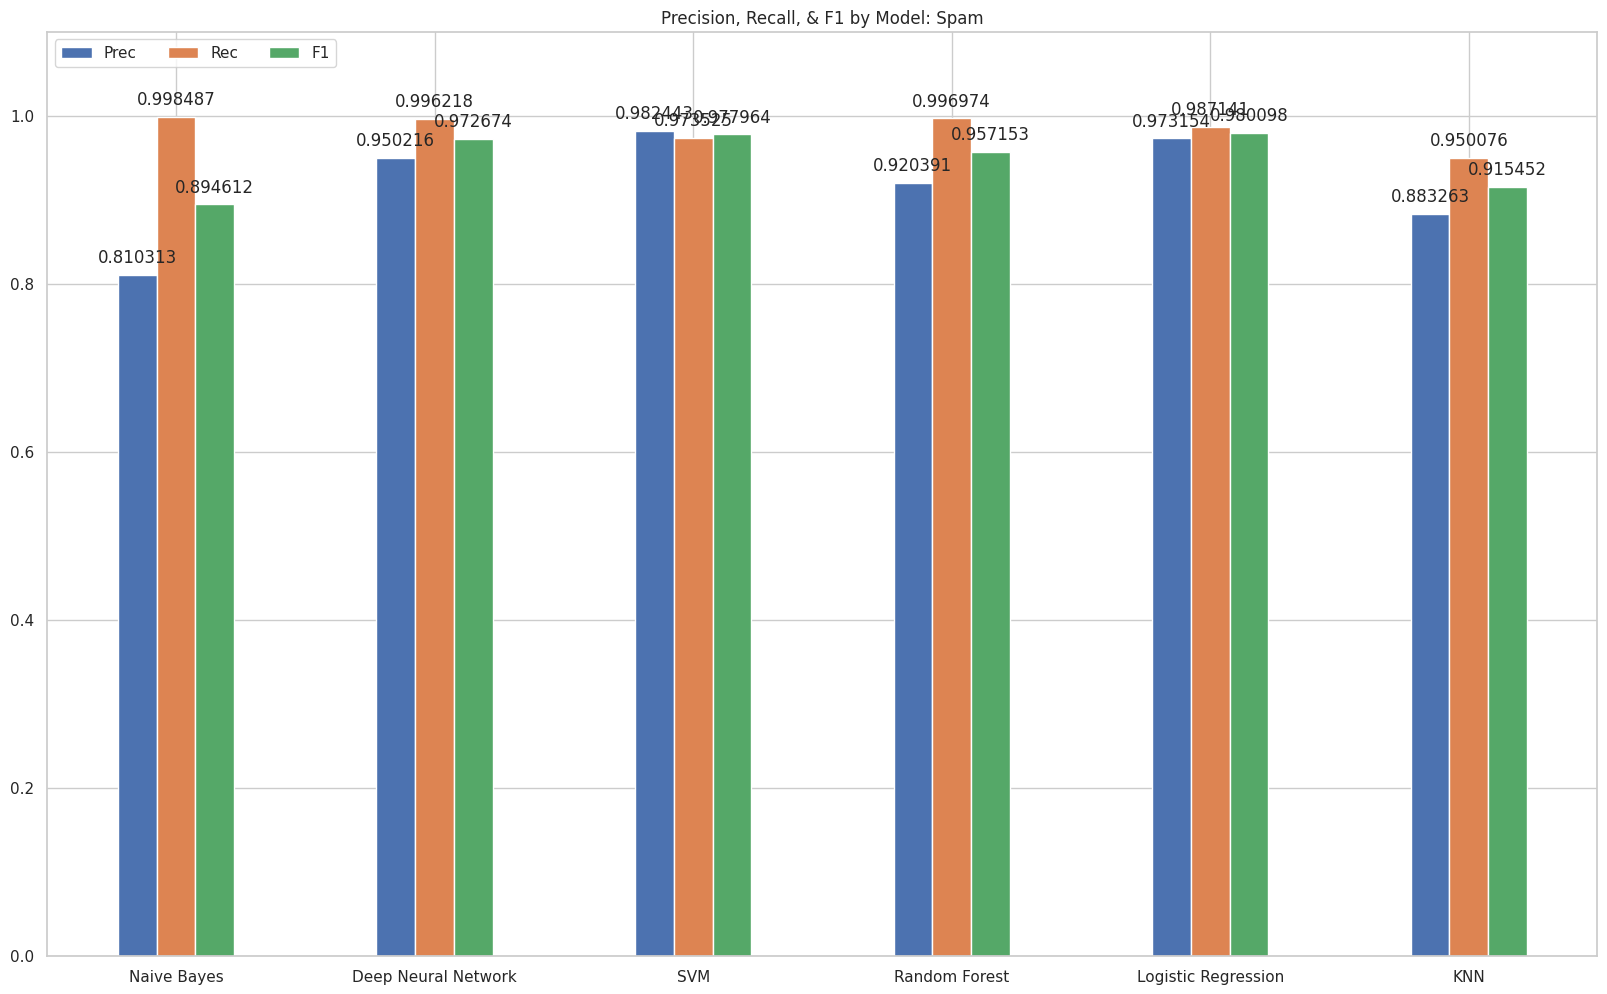

In [189]:
# Display Spam
fig, ax = plt.subplots()
fig.set_size_inches(20, 12)

x = np.arange(len(conf_mats.keys()))
width = 0.15
i = 0
for k, v in score_calcs.items():
  if k[-1] == 'S':
    offset = width * i
    rects = ax.bar(x + offset, v, width, label=k[:-2])
    ax.bar_label(rects, padding=6)
    i+=1

ax.set_title('Precision, Recall, & F1 by Model: Spam')
ax.set_xticks(x + width, models)
ax.legend(loc='upper left', ncols=6)
ax.set_ylim(0, 1.1)